# Небольшой отчет
Моей изначальной идеей было исполдьзование промптинга или fsl (few shot logic), то есть взять уже обученную хорошую языковую модель и подавать ей на вход несколько примеров, чтобы она уловила закономерности. Из таких моделей сейчас легко доступна толдько гпт3 (чат-гпт было бы здорово, но увы). В итоге оказалось, что не так уж хорошо она понимает контекст задания, у меня так и не получилось подобрать завтравки для ABSA (да и для SA вообще). При этом я знаю, что эту модель используют подобным образом

Я больше читала, чем что-то делала, и в итоге оно все не заработало, так что я просто допиливала бейзлайн, так как уже ни на что не оставалось времени.

Читала я вот что:
1. [Вот тут](https://towardsdatascience.com/gpt-3-parameters-and-prompt-design-1a595dc5b405) есть часть про суммаризацию, мне показалось, что это задача, близкая к той, что у нас есть, поэтому гпт должен уметь и просто извлечение сущностей решать
2. [Вот тут](https://blog.andrewcantino.com/blog/2021/04/21/prompt-engineering-tips-and-tricks/) я смотрела, как еще применяют промптинг
3. Потом я пошла читать про гпт, выяснила, что он претендует на прохождение теста Тьюринга, слишком увлеклась. 
4. есть еще две статьи, они совсем новые, но там описываются методы, сложные в реализации и требующие все-таки большего кол-ва данных: [один](https://arxiv.org/abs/2109.08306) и [два](https://aclanthology.org/2022.coling-1.610/)

В итоге я решила попробовать делат через близость к центроидам категории и центроидам сентимента, но не успела. А потом нашла ошибку в том, что делала с гпт, и поняла, что как раз там могло сработать...

# Установка всего нужного

In [122]:
!pip install stanza

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [123]:
import stanza
stanza.download('ru')

INFO:stanza:Downloading default packages for language: ru (Russian) ...
INFO:stanza:File exists: /root/stanza_resources/ru/default.zip
INFO:stanza:Finished downloading models and saved to /root/stanza_resources.


In [124]:
import numpy as np
from transformers import AutoTokenizer, AutoModel
import torch
from sklearn.model_selection import train_test_split
import sklearn
import pandas as pd
from collections import defaultdict, Counter
from tqdm.notebook import tqdm
import gensim
import seaborn as sns

In [125]:
!wget http://vectors.nlpl.eu/repository/20/220.zip

--2022-12-29 08:10:51--  http://vectors.nlpl.eu/repository/20/220.zip
Resolving vectors.nlpl.eu (vectors.nlpl.eu)... 129.240.189.181
Connecting to vectors.nlpl.eu (vectors.nlpl.eu)|129.240.189.181|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 638171816 (609M) [application/zip]
Saving to: ‘220.zip.1’

220.zip.1           100%[===================>] 608.61M  12.4MB/s    in 51s     

2022-12-29 08:11:43 (12.0 MB/s) - ‘220.zip.1’ saved [638171816/638171816]



In [126]:
import zipfile
with zipfile.ZipFile('220.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

In [127]:
w2v = gensim.models.KeyedVectors.load_word2vec_format(f'model.bin', binary=True)

Exception ignored in: <function tqdm.__del__ at 0x7f80a1c109d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/tqdm/std.py", line 1162, in __del__
    self.close()
  File "/usr/local/lib/python3.8/dist-packages/tqdm/notebook.py", line 288, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'


In [128]:
# model_name = "sberbank-ai/sbert_large_nlu_ru"
# tokenizer = AutoTokenizer.from_pretrained(model_name)
# model = AutoModel.from_pretrained(model_name)

# Чтение данных

In [129]:
!wget https://raw.githubusercontent.com/named-entity/hse-nlp/master/4th_year/Project/train_reviews.txt
!wget https://raw.githubusercontent.com/named-entity/hse-nlp/master/4th_year/Project/train_cats.txt
!wget https://raw.githubusercontent.com/named-entity/hse-nlp/master/4th_year/Project/train_aspects.txt

--2022-12-29 08:12:02--  https://raw.githubusercontent.com/named-entity/hse-nlp/master/4th_year/Project/train_reviews.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 446118 (436K) [text/plain]
Saving to: ‘train_reviews.txt.2’

train_reviews.txt.2 100%[===================>] 435.66K  --.-KB/s    in 0.003s  

2022-12-29 08:12:02 (124 MB/s) - ‘train_reviews.txt.2’ saved [446118/446118]

--2022-12-29 08:12:02--  https://raw.githubusercontent.com/named-entity/hse-nlp/master/4th_year/Project/train_cats.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting respon

In [130]:
texts, ids = [], []
with open('train_reviews.txt') as f:
    for line in f:
        text_id, text = line.rstrip('\r\n').split('\t')
        texts.append(text)
        ids.append(text_id)

In [131]:
train_texts, dev_texts, train_ids, dev_ids = train_test_split(texts, ids)

In [132]:
train_aspects, dev_aspects = [], []
with open('train_aspects.txt') as f:
    for line in f:
        line = line.rstrip('\r\n')
        text_id = line.split('\t')[0]
        if text_id in train_ids:
            train_aspects.append(line)
        if text_id in dev_ids:
            dev_aspects.append(line)

In [133]:
train_sentiment, dev_sentiment = [], []
with open('train_cats.txt') as f:
    for line in f:
        line = line.rstrip('\r\n')
        text_id = line.split('\t')[0]
        if text_id in train_ids:
            train_sentiment.append(line)
        if text_id in dev_ids:
            dev_sentiment.append(line)

In [134]:
with open('train_split_aspects.txt', 'w') as f:
    for l in train_aspects:
        print(l, file=f)
with open('dev_aspects.txt', 'w') as f:
    for l in dev_aspects:
        print(l, file=f)
with open('train_split_reviews.txt', 'w') as f:
    for i, l in zip(train_ids, train_texts):
        print(i, l, sep="\t", file=f)
with open('dev_reviews.txt', 'w') as f:
    for i, l in zip(dev_ids, dev_texts):
        print(i, l, sep="\t", file=f)
with open('train_split_cats.txt', 'w') as f:
    for l in train_sentiment:
        print(l, file=f)
with open('dev_cats.txt', 'w') as f:
    for l in dev_sentiment:
        print(l, file=f)

In [202]:
train_asp = pd.read_csv('train_aspects.txt', sep='\t', names=['idx', 'cat', 'asp', 'start', 'end', 'sent'])
train_cat = pd.read_csv('train_cats.txt', sep='\t', names=['idx', 'cat', 'sent'])
train_rev = pd.read_csv('train_reviews.txt', sep='\t', names=['idx', 'text'])

# Word2Vec

In [203]:
nlp = stanza.Pipeline('ru', processors='tokenize,lemma,pos')

INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Loading these models for language: ru (Russian):
| Processor | Package   |
-------------------------
| tokenize  | syntagrus |
| pos       | syntagrus |
| lemma     | syntagrus |

INFO:stanza:Use device: gpu
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: pos
INFO:stanza:Loading: lemma
INFO:stanza:Done loading processors!


In [204]:
def normalize(text):
    doc = nlp(text)
    words = [f'{word.lemma}_{word.pos}' for sent in doc.sentences for word in sent.words]
    return words

In [206]:
tqdm.pandas()
train_asp['lemm_asp'] = train_asp['asp'].progress_apply(lambda x: tuple(normalize(x)))

  0%|          | 0/4763 [00:00<?, ?it/s]

In [207]:
def get_embs(lst):
    res = []
    for asp in tqdm(lst):
        if asp[0] in w2v.vocab:
            vec = w2v[asp[0]]
        else:
            vec = np.random.uniform(0, 1, 300)
        for el in asp[1:]:
            if el in w2v.vocab:
                new_vec = w2v[el]
                vec = vec + new_vec
        res.append(vec)
    res = np.stack(res)
    return res

In [208]:
new_asps = train_asp.drop(columns=['idx', 'start', 'end', 'sent', 'asp']).drop_duplicates()
new_asps = new_asps.sort_values('cat')
texts = new_asps.lemm_asp.tolist()
vecs = get_embs(texts)

  0%|          | 0/1382 [00:00<?, ?it/s]

вот ту видно, что при сортировке по категориям получаестя не совсем ковер, что означает, что идея может сработать

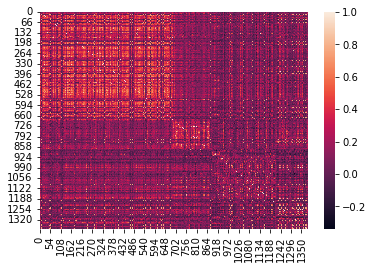

In [209]:
sns.heatmap(sklearn.metrics.pairwise.cosine_similarity(vecs))

Идея, хотя я не успеваю ее реализовать: 

Использовать несколько модифицированный кнн. Для каждого существительного (или коллокации, для них тоже должно работать) в тексте берем десять ближайших из обучения по косинусной близости. Смотрим, на максимальную близость, если она меньше определенного порога, то считаем, что это не аспект (гипотеза в том, что маленькое сходство с наиболее походим из набора будет у каких-то слов, совершенно не относящихся к задаче). Дальше выбираем категорию, наиболее бчастую среди этих 10 (можно попробовать менять числа, это гиперпараметр).

Для определения тональности можно использовать похожий метод, но нужен будет лексикон ( а может и нет): 
1. Вариант с лексиконом: обучаем кнн (или что-нибудь поприличнее, ту уже не так важно), чтобы классифицировать слова из лексикона на тональности. Потом берем окно с аспектом в центре и смотрим для всех слов класс по классификатору. Берем наиболее частотный. Можно смотреть не для кажлого, а для суммы веткоров. Можно сделать описанный для категорий подход вы чистом виде: брать десять ближайших из лексикона и для них самую частотную тональность.
2. Без лексикона: сначала на обучении берем окно с аспектом в центре, для всех слов считаем общий вектор, потом обучаем классификатор на определение тональности. Потом так же классифифцируем на этапе инференса.

In [225]:
def get_category(text, line=1):
    text = normalize(text)
    res = []
    words = []
    for tok in text:
        if tok in w2v.vocab and 'NOUN' in tok:
            res.append(w2v[tok])
            words.append(tok)
    words = np.array(words)
    res = np.stack(res)
    dist = sklearn.metrics.pairwise.cosine_similarity(vecs, res)
    top_idx = np.argsort(dist, axis=0)[-10:, :].transpose()
    top_val = np.sort(dist, axis=0)[-10:, :].transpose()
    top_val[top_val <= line] = 0
    top_val = np.sum(top_val, axis=1)
    top_idx = np.where(top_val != 0)
    return words[top_idx]

In [226]:
chk = train_asp[['idx', 'lemm_asp']].groupby('idx').agg(sum)
chk['idx'] = chk.index
chk.index = range(chk.shape[0])
chk = chk[['idx', 'lemm_asp']]
chk['lemm_asp_1'] = train_rev.text.progress_apply(get_category)

  0%|          | 0/284 [00:00<?, ?it/s]

In [229]:
chk['lemm_asp_99'] = train_rev.text.progress_apply(get_category, line=0.99)
chk['lemm_asp_95'] = train_rev.text.progress_apply(get_category, line=0.95)
chk['lemm_asp_9'] = train_rev.text.progress_apply(get_category, line=0.9)
chk['lemm_asp_8'] = train_rev.text.progress_apply(get_category, line=0.8)

  0%|          | 0/284 [00:00<?, ?it/s]

  0%|          | 0/284 [00:00<?, ?it/s]

  0%|          | 0/284 [00:00<?, ?it/s]

  0%|          | 0/284 [00:00<?, ?it/s]

In [230]:
def check_sim(line, n=0):
    s1 = set(line[1])
    s2 = set(line[n + 2])
    sand = s1 & s2
    s21 = s2 - s1
    s12 = s1 - s2
    return len(sand) / len(s1) # , len(s21) / len(s2), len(s12) / len(s1)

In [234]:
for n in range(5):
    chk[f'acc_{n}'] = chk.apply(check_sim, n=n, axis=1)

In [236]:
chk.head()

,idx,lemm_asp,lemm_asp_1,lemm_asp_99,lemm_asp_95,lemm_asp_9,lemm_asp_8,acc_0,acc_1,acc_2,acc_3,acc_4
0,280,"(ресторан_NOUN, персонал_NOUN, открыть_VERB, о...","[ресторан_NOUN, праздник_NOUN, ресторан_NOUN, ...","[март_NOUN, ресторан_NOUN, праздник_NOUN, рест...","[март_NOUN, ресторан_NOUN, праздник_NOUN, рест...","[март_NOUN, ресторан_NOUN, праздник_NOUN, рест...","[март_NOUN, ресторан_NOUN, праздник_NOUN, рест...",0.238095,0.380952,0.380952,0.380952,0.380952
1,343,"(ресторан_NOUN, еда_NOUN, официант_NOUN, интер...","[ресторан_NOUN, руководство_NOUN, ресторан_NOU...","[ресторан_NOUN, вечер_NOUN, руководство_NOUN, ...","[ресторан_NOUN, этаж_NOUN, вечер_NOUN, руковод...","[ресторан_NOUN, этаж_NOUN, вечер_NOUN, руковод...","[ресторан_NOUN, этаж_NOUN, вечер_NOUN, руковод...",0.200000,0.200000,0.200000,0.200000,0.200000
2,719,"(заказать_VERB, столик_NOUN, пиво_NOUN, хугард...","[впечатление_NOUN, посещение_NOUN, ресторан_NO...","[впечатление_NOUN, посещение_NOUN, ресторан_NO...","[впечатление_NOUN, посещение_NOUN, ресторан_NO...","[впечатление_NOUN, посещение_NOUN, ресторан_NO...","[впечатление_NOUN, посещение_NOUN, ресторан_NO...",0.111111,0.111111,0.111111,0.111111,0.111111
3,785,"(ресторан_NOUN, интерьер_NOUN, место_NOUN, укр...","[кафе_NOUN, повар_NOUN, блюдо_NOUN, атмосфера_...","[кафе_NOUN, повар_NOUN, блюдо_NOUN, обслуживан...","[кафе_NOUN, повар_NOUN, блюдо_NOUN, обслуживан...","[кафе_NOUN, повар_NOUN, блюдо_NOUN, обслуживан...","[кафе_NOUN, повар_NOUN, блюдо_NOUN, дело_NOUN,...",0.200000,0.200000,0.200000,0.200000,0.200000
4,797,"(ресторан_NOUN, выпить_VERB, чай_NOUN, вино_NO...","[заведение_NOUN, девушка_NOUN, столик_NOUN, пе...","[заведение_NOUN, сервис_NOUN, девушка_NOUN, ст...","[ноябрь_NOUN, заведение_NOUN, сервис_NOUN, дев...","[ноябрь_NOUN, заведение_NOUN, сервис_NOUN, дев...","[муж_NOUN, ноябрь_NOUN, заведение_NOUN, сервис...",0.142857,0.285714,0.285714,0.285714,0.285714


# GPT3 and prompting

Это была очень тестовая попытка с гпт, но оно работает скорее в сторону семантики, а не поиска эксплицитно вырааженных аспектов

In [107]:
model_name_or_path = "sberbank-ai/rugpt3large_based_on_gpt2"
tok = GPT2Tokenizer.from_pretrained(model_name_or_path)
model = GPT2LMHeadModel.from_pretrained(model_name_or_path).cuda()

In [108]:
def generate(
    model, tok, text,
    do_sample=True, max_length=50, repetition_penalty=5.0,
    top_k=5, top_p=0.95, temperature=1,
    num_beams=None,
    no_repeat_ngram_size=3
    ):
  input_ids = tok.encode(text, return_tensors="pt").cuda()
  out = model.generate(
      input_ids.cuda(),
      max_length=max_length,
      repetition_penalty=repetition_penalty,
      do_sample=do_sample,
      top_k=top_k, top_p=top_p, temperature=temperature,
      num_beams=num_beams, no_repeat_ngram_size=no_repeat_ngram_size
      )
  return list(map(tok.decode, out))

### RuGPT3Large

In [119]:
sent = 'Очень вкусная рыба, но без изысков. Чистые туалеты. И вообще хороший ресторан.'
sent1 = 'Красивое оформление, и цены нормальные.'
s = '''Input: Ресторан хороший, еда вкусная, правда цены высокие для такого заведения.
Output: ресторан, еда, цены

Input: Кормят отвратительно, но цены низкие, так что можно простить.
Output: цены

Input: Ресторан хороший, но мебель как в сарае.
Output: ресторан, мебель

Input: {sent}
Output:'''.format(sent=sent1)

In [120]:
generated = generate(model, tok, s, num_beams=10, max_length=150)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [121]:
print('\n\n\n'.join(generated))

Input: Ресторан хороший, еда вкусная, правда цены высокие для такого заведения.
Output: ресторан, еда, цены

Input: Кормят отвратительно, но цены низкие, так что можно простить.
Output: цены

Input: Ресторан хороший, но мебель как в сарае.
Output: ресторан, мебель

Input: Красивое оформление, и цены нормальные.
Output: интерьер<s>
Праздник к нам приходит... 

В связи с тем, что сегодня у меня день рождения, я хочу поздравить всех своих френдов (и не только) с этим замечательным праздником - Днем Рождения! Желаю вам здоровья, счастья


В итоге я совсем запуталась сначала во времени, а потом в собсвтенном коде. Но готова ответиь на любые вопросы/прийти на защиту и т.д. Мне очень хочется хотя бы 3-4 за проект...